# Object Detection For Species Classification

by Jamie McElhiney

## Problem Statement

Around 12% of current bird species are considered endangered, threatened or vulnerable in some way. Many birds play a crucial roll in ecological systems for both predator and prey. Bird species such as these are known as 'keystone species' that hold an invaluable presence in their respective ecosystems. For example, a lot of birds are host to a variety of parasites and flys that also hold weight within their food chains. Additionally, many birds aid in pollination of certain plant species and creation of subhabitats such as nests or entry points in trees (woodpecker). It is incredibly important to conserve these species for both ecological and humane reasons. Not to mention, birds are peculiar and amusing to us. It would be a shame to go out on a walk and not hear the specific chirping melody based on the regional species.  

What we can do is propose a habitat protection movement. Habitat loss and destruction are one of the leading causes of bird species extinction. We can discretely place cameras in areas we know there may be endangered species and are being considered for deforestation or other means of habitat disruption.   

We will attempt to train our own bird detection system so that we can appropriately assess the population and activity of specific species within our geographical regions of study. To do this, we will segment out our bird images with a selective search algorithm and use a CNN to classify these segments as foreground(our bird) or background. When we deploy our model, we will be able to localize our bird on a variety of images. This will help conservation efforts since we can deploy cameras that willdetect birds that could be endangered without human disruption.

## Executive Summary

We used a combination of images from Cal-Tech's bird data set . Cal-Tech's bird data set includes 200 species of around 80 images per species. We have abridged the dataset to 3 species of around 80 images per species. The species we will be considering include a Cardinal, Black-footed Albatross, and Western Meadowlark. The intended outcome of our study is to analyze various methods of segmentation and object detection, as opposed to produced a highly accurate bird classification model (although we will include classification). Image segmentation allows us to extract and separate different regions within our image. We are going to apply a selective search approach. We will then apply and evaluate a Convolutional Neural Network that will help us determine which segments are of interest (bird) and which are not (background noise, other animals,..so on)



Selective Search
- Diverse application of grouping/segmentation algorithms based on color/texture/shape  
- Proposes multiple regions of interest  
- Heirarchical 


As with many image recognition and object detection problems, we run into many recurrent and expected problems. We must consider how we will account for birds with different poses, facing different directions, leaning forwards or backwards, facing the camera or facing away, flying or standing, and so on. If we feed in images of birds in only certain poses, lets say all facing left, how will our detection system recognize a bird facing right. We also have to considered different background classes. Different bird species will habit different genres of terrain(what region are these species found in), and similarly we have to account for what season it is, weather conditions, time of day, lighting, etc.. We have accounted for some of these issues with data augmentation where we have generated copies of our original data with added noise that can be considered synonymous with camera inconsistencies (scratching,dust) and orientation flips (pose left,right). Our augmentation was minimal given time constraints and annotations, so we are avoiding rotation.

For both approaches, we fit and evaluated various classification algorithms in a binary setting (foreground,background). We use our annotated boundary boxes on our birds so we can retrieve suggested candidate regions for foreground objects. We calculated an Intersection over Union score (IoU) to determine how overlapped our proposed regions by our segmentation are with our ground truth (annoted labels) box. Regions with a score greater than 0.7 would be classified as foreground and regions with a score less than 0.3 would be classified as background. Scores between 0.7 and 0.3 are ignored. Our classification model consists out a multi layer Convalutional Network connected to a Fully Connected layer.

## Data Dictionary

| Name| Data Types (Pandas) | Description |
|---|---|---|
|root|object|root file path of image|
|filename|object|full filename plus doc ext of image file|
|w|int64|width of image|
|h|int64|height of image|
|x1|int64|first x-coordinate of bounding box|
|y1|int64|first y-coordinate of bounding box|
|x2|int64|second x-coordinate of bounding box|
|y2|int64|second y-coordinate of bounding box|


In [1]:
import tensorflow as tf
import IPython.display as display

In [2]:

import base64
from PIL import Image
import io

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3681736596173372400
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3135687884
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1749504428724029916
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sn
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten,Dense, ZeroPadding2D, Dropout, Input
from keras.callbacks import EarlyStopping

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, auc
from sklearn.preprocessing import LabelBinarizer

import xml.etree.ElementTree as ET

Using TensorFlow backend.


In [4]:
#load data with pandas
train_path='./data/bird2_train/'
test_path='./data/bird2_test/'

## Read in CVAT annotion file with XML parser

We performed annotations (labeled boundary boxes) on our images around birds so we can set up an object detection model. These annotations were performed in Computer Vision Annotation Tool (CVAT). CVAT spits out an XML containing our image metadata, such as image heigh, image width, boundary box coordinates, filename, and root filepath. We will parse through this XML with xml tree and create our initial dataframe.

In [5]:
def create_df_xml(input1):
    annotation=ET.parse(f'./data/bird2_{input1}/{input1}_annotations.xml')
    root=annotation.getroot()
    df_cols=['root','filename','w','h']
    df_rows=[]
    for node in root.iter('image'):
        #print (list(node.attrib.values()))
        s_root=f'/data/bird2_{input1}/'
        s_name=list(node.attrib.values())[1]
        s_height=list(node.attrib.values())[3]
        s_width=list(node.attrib.values())[2]
         
        
    
        df_rows.append({'root':s_root,'filename': s_name,'w':s_width,'h':s_height,
                            })
        x1=pd.DataFrame(df_rows, columns = df_cols)
    df_cols=['x1','x2','y1','y2']
    df_rows=[]
    for node in root.iter('image'):
        for node1 in node:
            s_x1=list(node1.attrib.values())[2]
            s_x2=list(node1.attrib.values())[4]
            s_y1=list(node1.attrib.values())[3]
            s_y2=list(node1.attrib.values())[5]
   
            df_rows.append({
                            'x1':s_x1,'x2':s_x2,'y1':s_y1,'y2':s_y2})
        x2=pd.DataFrame(df_rows,columns=df_cols)
    x4= pd.concat((x1,x2),axis=1)    
    return x4

In [6]:
#apply to test and train sets
test1=create_df_xml('test')
train1=create_df_xml('train')

In [7]:
print(train1.shape)
print(test1.shape)

(218, 8)
(102, 8)


In [8]:
#lets get a look at our data
train1.head()

root            filename    w    h      x1      x2     y1  \
0  /data/bird2_train/     Blue_Jay_00.jpg  600  391  102.39  444.90  52.38   
1  /data/bird2_train/    Blue_Jay_001.jpg  960  640  402.98  834.95  72.45   
2  /data/bird2_train/  Blue_Jay_00111.jpg  480  360   42.24  429.57  42.51   
3  /data/bird2_train/   Blue_Jay_0031.jpg  570  380  256.85  486.94  59.72   
4  /data/bird2_train/  Blue_Jay_00343.jpg  540  346  117.50  472.44  34.58   

       y2  
0  332.95  
1  435.10  
2  268.87  
3  309.25  
4  244.51

In [9]:
test1.head()

root                 filename    w    h      x1      x2  \
0  /data/bird2_test/  Blue_Jay_0002_62657.jpg  500  400  163.33  360.21   
1  /data/bird2_test/  Blue_Jay_0003_63408.jpg  500  332   24.35  292.56   
2  /data/bird2_test/  Blue_Jay_0006_63504.jpg  500  333  215.58  338.11   
3  /data/bird2_test/  Blue_Jay_0009_62873.jpg  500  312   79.40  302.91   
4  /data/bird2_test/  Blue_Jay_0013_61463.jpg  500  472  114.40  450.81   

       y1      y2  
0  132.04  274.34  
1   48.94  312.26  
2   68.15  209.74  
3   56.25  163.44  
4   95.43  458.86

In [10]:
#some quick conversions
train1['w']=train1['w'].astype(int)
train1['h']=train1['h'].astype(int)
train1['x1']=train1['x1'].astype(float).round().astype(int)
train1['x2']=train1['x2'].astype(float).round().astype(int)
train1['y1']=train1['y1'].astype(float).round().astype(int)
train1['y2']=train1['y2'].astype(float).round().astype(int)

In [11]:
test1['w']=test1['w'].astype(int)
test1['h']=test1['h'].astype(int)
test1['x1']=test1['x1'].astype(float).round().astype(int)
test1['x2']=test1['x2'].astype(float).round().astype(int)
test1['y1']=test1['y1'].astype(float).round().astype(int)
test1['y2']=test1['y2'].astype(float).round().astype(int)

## Image Augmentation

Augmentation is different from preprocessing in the sense that it is only applied on our training data. It is used to make our data more robust so we can account for a broader variety of image classes. 

### Read in TF Record from Roboflow

Roboflow is an online augmentation platform that allows us to perform augmentations on our image that will also be applied to our annotations. We uploaded our images and their associated annotations and applied several augmentations per image including: random rotation, horizontal flip, noise generation, and brightness adjustment. We then generate a TFRecord from Roboflow and followed the tensorflow documentation to read in, write our images, and .

In [12]:
# followed TF documentation https://www.tensorflow.org/tutorials/load_data/tfrecord
raw_image_dataset = tf.data.TFRecordDataset('./data/train/birds.tfrecord')

In [13]:
image_feature_description = {
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin':tf.io.FixedLenFeature([], tf.float32),
    'image/object/bbox/xmax':tf.io.FixedLenFeature([], tf.float32),
    'image/object/bbox/ymin':tf.io.FixedLenFeature([], tf.float32),
    'image/object/bbox/ymax':tf.io.FixedLenFeature([], tf.float32)

}

In [14]:
def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {image/encoded: (), image/filename: (), image/height: (), image/object/bbox/xmax: (), image/object/bbox/xmin: (), image/object/bbox/ymax: (), image/object/bbox/ymin: (), image/width: ()}, types: {image/encoded: tf.string, image/filename: tf.string, image/height: tf.int64, image/object/bbox/xmax: tf.float32, image/object/bbox/xmin: tf.float32, image/object/bbox/ymax: tf.float32, image/object/bbox/ymin: tf.float32, image/width: tf.int64}>

In [15]:

df_cols=['root','filename','w','h','x1','x2','y1','y2']
df_rows=[]

for i,image_features in enumerate(parsed_image_dataset):
    
    ##grab data from our parsed TFRecord file
    s_root='/data/bird2_train/'
    image_raw = image_features['image/encoded'].numpy()
    image_height=image_features['image/height'].numpy()
    image_width=image_features['image/width'].numpy()
    image_x1=int(round(image_features['image/object/bbox/xmin'].numpy()*image_width))
    image_x2=int(round(image_features['image/object/bbox/xmax'].numpy()*image_width))
    image_y1=int(round(image_features['image/object/bbox/ymin'].numpy()*image_height))
    image_y2=int(round(image_features['image/object/bbox/ymax'].numpy()*image_height))
    filename=str(image_features['image/filename'].numpy())
    ##extract filename
    start = "b'"
    end = ".rf"
    s = filename
    filename=s[s.find(start)+len(start):s.rfind(end)]
    
    #write out and save image to our training folder
    image = Image.open(io.BytesIO(image_raw))
    image.save(f'./data/bird2_train/{filename}_{i}'+'.jpg', 'jpeg')
    filename=f'{filename}_{i}'
    #put data into dataframe
    df_rows.append({'root':s_root,'filename':filename+'.jpg','w':image_width,'h':image_height,'x1':image_x1,'x2':image_x2,
                    'y1':image_y1,'y2':image_y2
                            })
x4=pd.DataFrame(df_rows, columns = df_cols)


In [16]:
x4

root                                   filename    w    h  \
0    /data/bird2_train/    Western_Meadowlark_0050_77864_jpg_0.jpg  500  400   
1    /data/bird2_train/                    Blue_Jay_0087_jpg_1.jpg  307  415   
2    /data/bird2_train/    Western_Meadowlark_0112_78760_jpg_2.jpg  500  400   
3    /data/bird2_train/          Horned_Grebe_0049_34779_jpg_3.jpg  500  333   
4    /data/bird2_train/    Western_Meadowlark_0021_78841_jpg_4.jpg  333  500   
..                  ...                                        ...  ...  ...   
423  /data/bird2_train/      Red_Winged_Blackbird_0097_jpg_423.jpg  750  552   
424  /data/bird2_train/  Western_Meadowlark_0115_77882_jpg_424.jpg  500  439   
425  /data/bird2_train/  Western_Meadowlark_0034_78869_jpg_425.jpg  461  500   
426  /data/bird2_train/             Gadwall_0060_31686_jpg_426.jpg  500  333   
427  /data/bird2_train/            Blue_Jay_0081_61714_jpg_427.jpg  500  333   

      x1   x2   y1   y2  
0    126  396  110  272  
1     16  271   45  321  
2    149  382   14  303  
3    125  441   55  262  
4    109  216   56  151  
..   ...  ...  ...  ...  
423  146  650   90  365  
424  164  379   54  327  
425  204  326  157  302  
426  112  424   78  296  
427  123  342   51  202  

[428 rows x 8 columns]

#### Noise

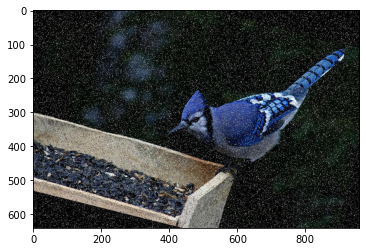

In [17]:
image = cv2.imread('.'+x4['root'][17]+x4['filename'][12])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

#### Random Rotation

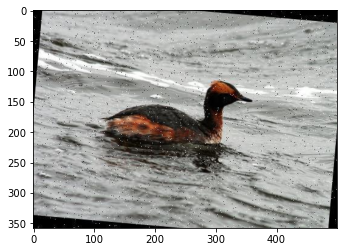

In [18]:
image = cv2.imread('.'+x4['root'][26]+x4['filename'][26])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

#### Noise + Rotation

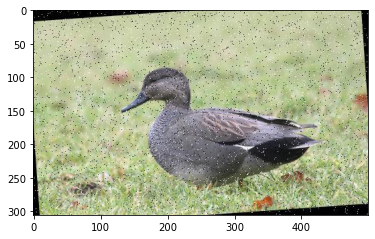

In [19]:
image = cv2.imread('.'+x4['root'][47]+x4['filename'][54])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [20]:
train2=pd.concat((train1,x4),ignore_index=True)

In [21]:
train2.head(15)

root                 filename    w    h   x1   x2   y1   y2
0   /data/bird2_train/          Blue_Jay_00.jpg  600  391  102  445   52  333
1   /data/bird2_train/         Blue_Jay_001.jpg  960  640  403  835   72  435
2   /data/bird2_train/       Blue_Jay_00111.jpg  480  360   42  430   43  269
3   /data/bird2_train/        Blue_Jay_0031.jpg  570  380  257  487   60  309
4   /data/bird2_train/       Blue_Jay_00343.jpg  540  346  118  472   35  245
5   /data/bird2_train/  Blue_Jay_0038_62784.jpg  480  500  225  440  124  445
6   /data/bird2_train/  Blue_Jay_0044_62759.jpg  500  333   72  274   75  285
7   /data/bird2_train/  Blue_Jay_0048_62433.jpg  500  393  227  475   74  309
8   /data/bird2_train/  Blue_Jay_0049_63082.jpg  328  500   86  246  103  341
9   /data/bird2_train/  Blue_Jay_0050_62974.jpg  500  355   64  370   85  268
10  /data/bird2_train/  Blue_Jay_0052_63148.jpg  500  393  185  459   33  262
11  /data/bird2_train/  Blue_Jay_0053_62744.jpg  500  408   86  424   95  296
12  /data/bird2_train/  Blue_Jay_0054_61656.jpg  500  468  197  301  109  262
13  /data/bird2_train/  Blue_Jay_0055_61507.jpg  500  333   70  378   31  236
14  /data/bird2_train/  Blue_Jay_0060_62570.jpg  500  400   55  333  109  308

## Ground truth boxes 

In [22]:
train2['filename'][5]

'Blue_Jay_0038_62784.jpg'

In [23]:
'.'+train2['root'][5]+train2['filename'][5]

'./data/bird2_train/Blue_Jay_0038_62784.jpg'

In [24]:
def bbox_plot(i):

    image = cv2.imread('.'+train2['root'][i]+train2['filename'][i])
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x1=train2['x1'][i]
    x2=train2['x2'][i]
    y1=train2['y1'][i]
    y2=train2['y2'][i]

    fig,ax = plt.subplots(1)
    ax.imshow(image)
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3,edgecolor=np.random.rand(3,),facecolor='none')
    ##(x1,y1),x2-x1,y2-y1
    ax.add_patch(rect)
    print(x1,x2,y1,y2)
    return plt.imshow(image)

In [25]:
def bbox_plot1(i):

    image = cv2.imread('.'+test1['root'][i]+test1['filename'][i])
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x1=test1['x1'][i]
    x2=test1['x2'][i]
    y1=test1['y1'][i]
    y2=test1['y2'][i]

    fig,ax = plt.subplots(1)
    ax.imshow(image)
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3,edgecolor=np.random.rand(3,),facecolor='none')
    ##(x1,y1),x2-x1,y2-y1
    ax.add_patch(rect)
    print(x1,x2,y1,y2)
    return plt.imshow(image)

108 385 91 280


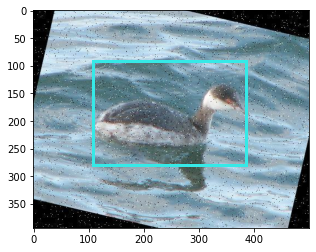

In [26]:
bbox_plot(291)

56 278 124 280


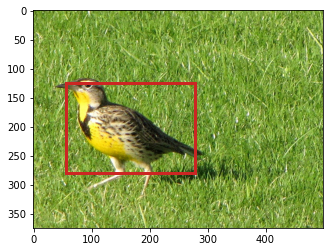

In [27]:
bbox_plot(212)

## Region Proposal System

In [28]:
#https://www.pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/
#https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/

In [29]:
#http://www.huppelen.nl/publications/selectiveSearchDraft.pdf

We're going to be using OpenCVs selective search segmentation algorithm. Please refer to the above paper if you would like a more in depth look of how Selective Search was built off its predecessors. In general, Selective Search applies a wide variety of algorithms on multiples scales and looks to segment out images. The segmentations are based on region characteristics and similarities in color,texture, and size. OpenCVs method of segmentations returns the coordinates for us in a bounding box format.

### Segmentation Examples

In [30]:
#read in our image and convert to color
image = cv2.imread('.'+train2['root'][14]+train2['filename'][14])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

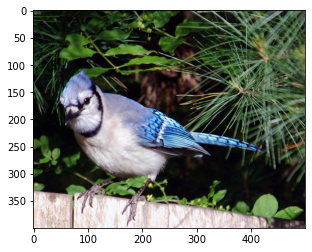

In [31]:
plt.imshow(image)

Basic color image of our cardinal we want to segment.

In [32]:
cv2.setUseOptimized(True)

In [33]:
##Initiate Segmentation
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
##Set base image to our specific ingest image
ss.setBaseImage(image)

In [34]:
%%time
##Selecting Quality Search over Fast, lower recall rate but higher rate of proposals
##(refer to #http://www.huppelen.nl/publications/selectiveSearchDraft.pdf)
ss.switchToSelectiveSearchFast()
##Process our image
rects = ss.process()
print(f'we have {len(rects)} proposals')

we have 2263 proposals
Wall time: 5.42 s


In [35]:
rects[:5]

array([[190, 227,  40,  23],
       [ 65,  11,  21,  21],
       [127,  63,  99,  39],
       [  0,   0,  49,  11],
       [332, 143,  48,  30]], dtype=int32)

As we see above, ss.process() returns x1,y1, w,h coordinates of its segmented regions. Lets display the top 200 proposals from our algorithm.

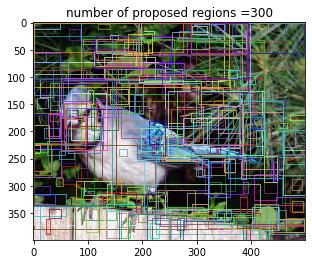

In [36]:
imOut = image.copy()
fig,ax = plt.subplots(1)
t1=300
#loop through proposal coordinates
for i, rect in enumerate(rects):
    #for proposal count less than our threshold, display these proposals on our image
    if (i < t1):
        x, y, w, h = rect
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor=np.random.rand(3,),facecolor='none')
        ax.add_patch(box)
plt.title(f'number of proposed regions ={t1}')
    
plt.imshow(imOut)

One of our cardinal images that has been segmented with Quality Segmentation. Top 300 Regions.

In [37]:
image = cv2.imread('.'+test1['root'][19]+test1['filename'][19])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchQuality()
rects = ss.process()
print(f'we have {len(rects)} proposals')


we have 1663 proposals


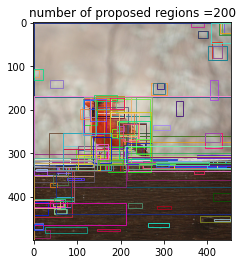

In [38]:
imOut = image.copy()
fig,ax = plt.subplots(1)
t1=200
for i, rect in enumerate(rects):
    if (i < t1):
        x, y, w, h = rect
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor=np.random.rand(3,),facecolor='none')
        ax.add_patch(box)
plt.title(f'number of proposed regions ={t1}')

        
plt.imshow(imOut)

## Calculate Intersection over Unioin

In [39]:
#https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

The IoU is a ratio or 'score' associating how overlapped the proposed regions with our ground truth boxes. This is a common technique in pretty much every version of region-based CNNs. A score of 1 is one box totally overlaps the other, and 0 is there is no overlap. For our boundary box regression? problem, we will assign 1 to regions with a score of over 0.7 and 0 to regions with an IoU score of 0.3 and assignt nothing to those inbetween. We will also pass along our strong iou score windows for Feature Mapping(CNN).

The thing is smaller boxes still totally INSIDE the ground truth box will stll have LOW scores if they are way smaller than the ground truth box ...consider this.

In [40]:
def calc_iou(box1,box2):

    left_max=max(box1['x1'],box2['x1'])
    right_min=min(box1['x2'],box2['x2'])
    top_min=min(box1['y2'],box2['y2'])
    bottom_max=max(box1['y1'],box2['y1'])
    
    if right_min < left_max or top_min < bottom_max:
        return 0.0
    
    area_of_intersect=(right_min-left_max)*(top_min-bottom_max)
    area_of_union=((box1['y2']-box1['y1'])*(box1['x2']-box1['x1']))+((box2['y2']-box2['y1'])*(box2['x2']-box2['x1']))-area_of_intersect
    iou=(area_of_intersect)/(area_of_union)
    assert iou >= 0.0
    assert iou <= 1.0

    return iou

Were going to loop through each image, get the ground truth box, run segmentation, utilize our IoU function, label regions with 1 for high iou and 0 for low iou and save all to list. We then do a binary classification problem on these regions 

### High IoU Score Examples

In [41]:
image = cv2.imread('.'+test1['root'][43]+test1['filename'][43])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
#rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))

In [42]:
len(rects)

2002

In [43]:
box1={}
box1['x1']=round(float(test1['x1'][43]))
box1['x2']=round(float(test1['x2'][43]))
box1['y1']=round(float(test1['y1'][43]))
box1['y2']=round(float(test1['y2'][43]))

Text(0.5, 1.0, '6 Regions w. IoU > 0.7')

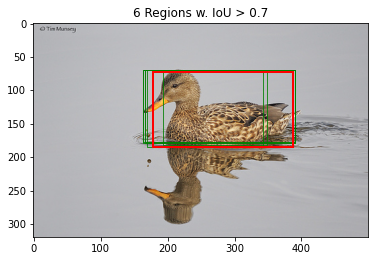

In [44]:
fig,ax = plt.subplots(1)
count=0
for i,item in enumerate(rects):
    box2={}
    box2['x1']=rects[i][0]
    box2['y1']=rects[i][1]
    box2['x2']=rects[i][0]+rects[i][2]
    box2['y2']=rects[i][1]+rects[i][3]
    iou=calc_iou(box1,box2)
    if iou>0.7:
        x, y, w, h = rects[i]
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor='green',facecolor='none')
        ax.add_patch(box)

        count+=1
box3=patches.Rectangle((box1['x1'],box1['y1']),box1['x2']-box1['x1'],box1['y2']-box1['y1'],linewidth=2,edgecolor='red',facecolor='none')
ax.add_patch(box3)
plt.imshow(image)
plt.title(f'{count} Regions w. IoU > 0.7')

Red box is our ground truth box. Green boxes are segmentations with IoU score > 0.7

In [45]:
image = cv2.imread('.'+train1['root'][15]+train1['filename'][15])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
len(rects)
box1={}
box1['x1']=round(float(train1['x1'][15]))
box1['x2']=round(float(train1['x2'][15]))
box1['y1']=round(float(train1['y1'][15]))
box1['y2']=round(float(train1['y2'][15]))

Text(0.5, 1.0, '11 Regions w. IoU > 0.7')

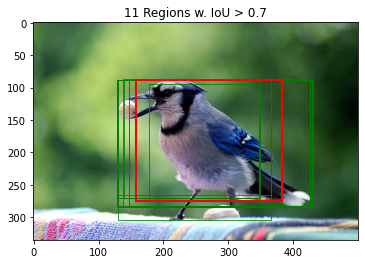

In [46]:
fig,ax = plt.subplots(1)
count=0
for i,item in enumerate(rects):
    box2={}
    box2['x1']=rects[i][0]
    box2['y1']=rects[i][1]
    box2['x2']=rects[i][0]+rects[i][2]
    box2['y2']=rects[i][1]+rects[i][3]
    iou=calc_iou(box1,box2)
    if iou>0.7:
        x, y, w, h = rects[i]
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor='green',facecolor='none')
        ax.add_patch(box)

        count+=1
box3=patches.Rectangle((box1['x1'],box1['y1']),box1['x2']-box1['x1'],box1['y2']-box1['y1'],linewidth=2,edgecolor='red',facecolor='none')
ax.add_patch(box3)
plt.imshow(image)
plt.title(f'{count} Regions w. IoU > 0.7')

Text(0.5, 1.0, '33 Regions w. IoU > 0.7')

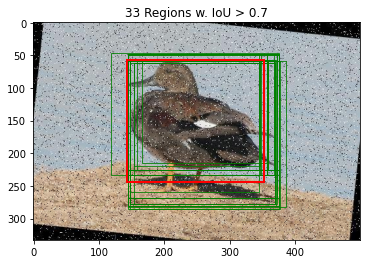

In [47]:
image = cv2.imread('.'+train2['root'][151]+train2['filename'][293])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
len(rects)
box1={}
box1['x1']=round(float(train2['x1'][293]))
box1['x2']=round(float(train2['x2'][293]))
box1['y1']=round(float(train2['y1'][293]))
box1['y2']=round(float(train2['y2'][293]))


fig,ax = plt.subplots(1)
count=0
for i,item in enumerate(rects):
    box2={}
    box2['x1']=rects[i][0]
    box2['y1']=rects[i][1]
    box2['x2']=rects[i][0]+rects[i][2]
    box2['y2']=rects[i][1]+rects[i][3]
    iou=calc_iou(box1,box2)
    if iou>0.7:
        x, y, w, h = rects[i]
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor='green',facecolor='none')
        ax.add_patch(box)

        count+=1
box3=patches.Rectangle((box1['x1'],box1['y1']),box1['x2']-box1['x1'],box1['y2']-box1['y1'],linewidth=2,edgecolor='red',facecolor='none')
ax.add_patch(box3)
plt.imshow(image)
plt.title(f'{count} Regions w. IoU > 0.7')

In [48]:
print(train2.shape)
test1.shape

(646, 8)


(102, 8)

## Model Setup

#### WARNING Long Process time. Preforming segmentation on our training data set.

This tidbit of code will set up our binary classifier data but cropping out all the segments with greater than 0.7 IoU score, resizing them all to same size (need to do this to fit a model) and then appending them to our data set with a label of 1 for >0.7 IoU or 0 for <0.3 IoU score. We will disregard regions in between.

In [49]:
#Initiate training data set
train_images=[]
train_labels=[]

In [50]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

FIND AND REPLACE TRAIN2 OR TRAIN1 to use augmented or unaugmented data, respectively.

In [51]:
##code adopted from 
##https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

#loop through our dataframe and get our image filenames to read in
for i,item in enumerate(train2['filename']):
    try:
        #get our ground truth box
        box1={}
        box1['x1']=round(float(train2['x1'][i]))
        box1['x2']=round(float(train2['x2'][i]))
        box1['y1']=round(float(train2['y1'][i]))
        box1['y2']=round(float(train2['y2'][i]))
        
        
        #read in image
        image = cv2.imread('.'+train2['root'][i]+train2['filename'][i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #run selective search
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        #apply filters
#        rects = list(filter(lambda x : x[2]<x[3]*10 and x[3]<x[2]*10, rects))
#         if (box1['x2']-box1['x1'])>(box1['y2']-box1['y1']):
#             rects = list(filter(lambda x : x[2]>x[3], rects))
#         else:
#             rects = list(filter(lambda x : x[2]<=x[3], rects))
    
#         rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))
        
        imout=image.copy()
        
        #we want to set some limits to the number of classes we assign per image
        #we dont want to have unbalanced classes so we set a limit of 30 regions per image per label
        counter1=0
        counter2=0
        flag=0
        fflag=0
        bflag=0
        ##loop through proposed regions
        for j,item in enumerate(rects):
            #get top 2000 regions
            if j<2000 and flag==0:
                #assign proposed region coordinates to coordinate dictionary, similiar to our ground truth box.
                box3={}
                box3['x1']=rects[j][0]
                box3['y1']=rects[j][1]
                box3['x2']=rects[j][0]+rects[j][2]
                box3['y2']=rects[j][1]+rects[j][3]
                #calculate IoU score of ground truth with proposal
                iou_score=calc_iou(box1,box3)
                #check to make sure there are less than 40 positive classes for this image
                if counter1<30:
                    #if IoU score is high, greater than 0.7 lets assign it to positive class 1
                    if iou_score>0.7:
                        #crop out proposal
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']]
                        #resize for model input resampling using pixel area relation
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        #add image data to our train set
                        train_images.append(resized)
                        #append positive class
                        train_labels.append(1)
                        #increment counter
                        counter1+=1
                       # print('yes')
                else:
                    fflag=1
                if counter2<20:
                    #if iou_score is low, less than 0.3 lets assign it to negative class 0
                    if iou_score<0.3:
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']] 
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        train_images.append(resized)
                        train_labels.append(0)
                        counter2+=1
                
                else:
                    bflag=1
            #If we have 70 regions for botch classes within the image, we move on        
            if fflag==1 and bflag==1:
               # print('inside')
                flag=1
    except Exception as j:
        print(j)
            
            
            
    
            
        

In [52]:
print(len(train_images))
print(len(train_labels))

17792
17792


In [53]:
count=0
for i in train_labels:
    if i==1:
        count+=1
print(count)

4872


unbalanced classes

### Preform same steps on test data

We will preform the exact same preprocessing steps to our test data, refer to above cells.

In [54]:
test_images=[]
test_labels=[]

In [55]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [56]:
for i,item in enumerate(test1['filename']):
    try:

        box1={}
        box1['x1']=round(float(test1['x1'][i]))
        box1['x2']=round(float(test1['x2'][i]))
        box1['y1']=round(float(test1['y1'][i]))
        box1['y2']=round(float(test1['y2'][i]))
        
        
        
        image = cv2.imread('.'+test1['root'][i]+test1['filename'][i])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ss.setBaseImage(image)

        
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        imout=image.copy()
        
        counter1=0
        counter2=0
        flag=0
        fflag=0
        bflag=0
        for j,item in enumerate(rects):
            if j<2000 and flag==0:
                box3={}
                box3['x1']=rects[j][0]
                box3['y1']=rects[j][1]
                box3['x2']=rects[j][0]+rects[j][2]
                box3['y2']=rects[j][1]+rects[j][3]
                iou_score=calc_iou(box1,box3)
                if counter1<40:
                    if iou_score>0.7:
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']]
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        test_images.append(resized)
                        test_labels.append(1)
                        counter1+=1
                       # print('yes')
                else:
                    fflag=1
                if counter2<40:
                    if iou_score<0.3:
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']] 
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        test_images.append(resized)
                        test_labels.append(0)
                        counter2+=1
                
                else:
                    bflag=1
                    
            if fflag==1 and bflag==1:
               # print('inside')
                flag=1
    except Exception as j:
        print(j)
            
    

### Positive sample

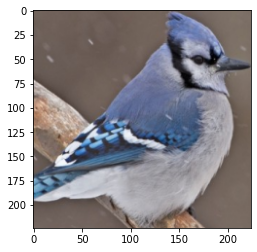

In [57]:
for i,(image,label) in enumerate(zip(train_images,train_labels)):
    if label==1:
        plt.imshow(image)
        break

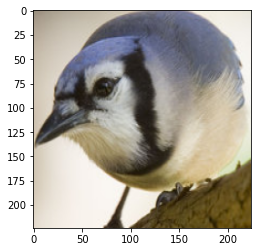

In [58]:
for i,(image,label) in enumerate(zip(test_images,test_labels)):
    if label==1:
        plt.imshow(image)
        break

### Negative sample

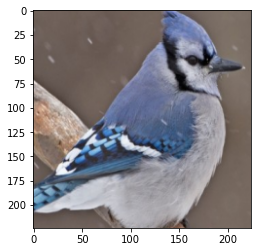

In [59]:
for i,(image,label) in enumerate(zip(train_images,train_labels)):

    if label==0:
       plt.imshow(image)
       break

NameError: name 'X_test' is not defined

## Modeling

### Baseline

First, let us determine a baseline accuracy score to compare against. Since we are doing a binary classification model, our baseline should be .50

In [61]:
print(len(test_images))
print(len(test_labels))

5177
5177


In [62]:
count=0
for i in test_labels:
    if i==1:
        count+=1
print(count)

1097


In [63]:
X_train=np.array(train_images)

In [64]:
X_train.shape

(17792, 224, 224, 3)

In [65]:
y_train=np.array(train_labels)

In [66]:
X_test=np.array(test_images)

In [67]:
y_test=np.array(test_labels)

In [68]:
X_test.shape

(5177, 224, 224, 3)

0


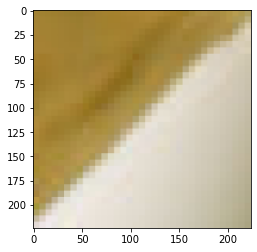

In [69]:
plt.imshow(X_test[31])
print(y_test[31])

## Binary Classifier with CNN

In [70]:
X_train.shape

(17792, 224, 224, 3)

In [239]:
cnn=Sequential()
cnn.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
cnn.add(Conv2D(32,(3,3),activation='relu'))
cnn.add(MaxPooling2D((2,2), strides=(2,2)))
          

cnn.add(Conv2D(64,(3,3),activation='relu'))
cnn.add(Conv2D(64,(3,3),activation='relu'))
cnn.add(MaxPooling2D((2,2), strides=(2,2)))
          
cnn.add(Conv2D(128,(3,3),activation='relu'))
cnn.add(Conv2D(128,(3,3),activation='relu'))
cnn.add(MaxPooling2D((2,2), strides=(2,2)))    
          

# cnn.add(Conv2D(256, (3, 3), activation='relu'))
# cnn.add(Conv2D(256, (3, 3), activation='relu'))
# cnn.add(MaxPooling2D((2,2), strides=(2,2)))
          
# cnn.add(Conv2D(512, (3, 3), activation='relu'))
# cnn.add(Conv2D(512, (3, 3), activation='relu'))
# cnn.add(Conv2D(512, (3, 3), activation='relu'))

# cnn.add(MaxPooling2D((2,2), strides=(2,2)))
        
cnn.add(Flatten())
        
# cnn.add(Dense(1024,activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.2))

          


In [240]:
cnn.add(Dense(1,activation='sigmoid'))


In [241]:
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [242]:
early_stop=EarlyStopping(monitor='val_binary_accuracy',min_delta=0,patience=5,verbose=1,mode='auto')

In [243]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 51, 51, 128)      

In [244]:
history1 = cnn.fit(X_train,
                        y_train,
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        epochs=20,
                        verbose=1,callbacks=[early_stop])

Train on 17792 samples, validate on 5177 samples
Epoch 1/20
17792/17792 [==============================] - 162s 9ms/sample - loss: 1.0447 - binary_accuracy: 0.7298 - val_loss: 0.6064 - val_binary_accuracy: 0.7879
Epoch 2/20
17792/17792 [==============================] - 159s 9ms/sample - loss: 0.4219 - binary_accuracy: 0.7390 - val_loss: 0.6457 - val_binary_accuracy: 0.3355
Epoch 3/20
17792/17792 [==============================] - 158s 9ms/sample - loss: 0.3888 - binary_accuracy: 0.7787 - val_loss: 0.5084 - val_binary_accuracy: 0.8764
Epoch 4/20
17792/17792 [==============================] - 158s 9ms/sample - loss: 0.2382 - binary_accuracy: 0.9191 - val_loss: 0.3600 - val_binary_accuracy: 0.8507
Epoch 5/20
17792/17792 [==============================] - 158s 9ms/sample - loss: 0.1909 - binary_accuracy: 0.9302 - val_loss: 0.1665 - val_binary_accuracy: 0.9336
Epoch 6/20
17792/17792 [==============================] - 160s 9ms/sample - loss: 0.1165 - binary_accuracy: 0.9554 - val_loss: 0.14

## Results & Evaluation

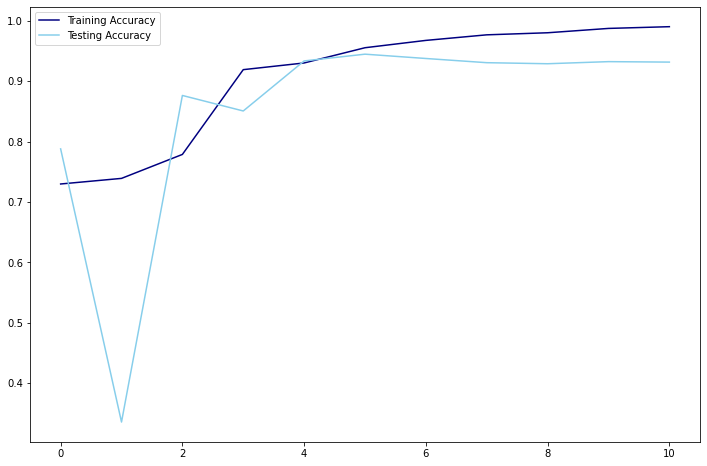

In [245]:
train_loss=history1.history['binary_accuracy']
test_loss=history1.history['val_binary_accuracy']
plt.figure(figsize=(12,8))
plt.plot(train_loss,label='Training Accuracy', color='navy')
plt.plot(test_loss,label='Testing Accuracy',color='skyblue')
plt.legend();

As we can see from our loss graph above, our model is somewhat overfit with testing loss increasing sightly as train loss decreases. We can combat overfitting by applying more augmentations, more regularization, or simplifying our model.

In [246]:
preds=cnn.predict(X_test)

In [247]:
preds[:5]

array([[2.2538360e-11],
       [3.0198098e-08],
       [6.2021801e-09],
       [2.2549318e-19],
       [9.8446362e-06]], dtype=float32)

In [248]:
test2=pd.DataFrame(y_test)

In [249]:
preds=pd.DataFrame(preds)

In [250]:
x=pd.concat((preds,test2),axis=1,ignore_index=False)

In [251]:
x.columns = ['pbird','isbird']

### True Positives

In [252]:
x[(x['pbird']>0.5)&(x['isbird']==1)].head()

pbird  isbird
40  0.992269       1
41  0.967920       1
42  0.992670       1
43  0.977786       1
44  0.999341       1

In [253]:
TP=x[(x['pbird']>0.5)&(x['isbird']==1)].shape[0]
TP

877

Correct positive predictions

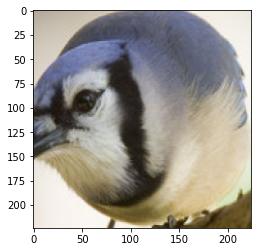

In [254]:
plt.imshow(X_test[46])

### True Negatives

In [255]:
x[(x['pbird']<0.5)&(x['isbird']==0)].head()

pbird  isbird
0  2.253836e-11       0
1  3.019810e-08       0
2  6.202180e-09       0
3  2.254932e-19       0
4  9.844636e-06       0

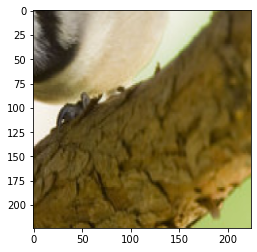

In [256]:
plt.imshow(X_test[4])

In [257]:
TN=x[(x['pbird']<0.5)&(x['isbird']==0)].shape[0]
TN

3946

### False Positives

In [258]:
x[(x['pbird']>0.5)&(x['isbird']==0)].head()

pbird  isbird
6    0.814128       0
28   0.504596       0
121  0.770212       0
123  0.850750       0
128  0.997851       0

In [259]:
FP=x[(x['pbird']>0.5)&(x['isbird']==0)].shape[0]
FP

134

Predicted as bird but is background

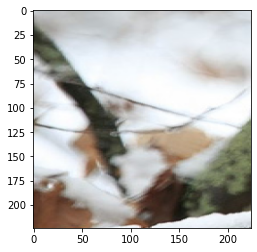

In [260]:
plt.imshow(X_test[123])

### False Negatives

In [261]:
x[(x['pbird']<0.5)&(x['isbird']==1)].head()


pbird  isbird
47  0.001720       1
51  0.003181       1
53  0.000067       1
54  0.350671       1
56  0.354845       1

In [262]:
FN=x[(x['pbird']<0.5)&(x['isbird']==1)].shape[0]
FN

220

Being predicted as background but is foreground.

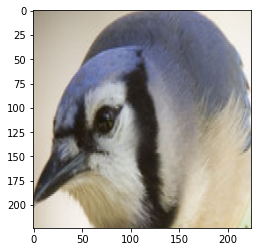

In [263]:
plt.imshow(X_test[47])

## Confusion Matrix

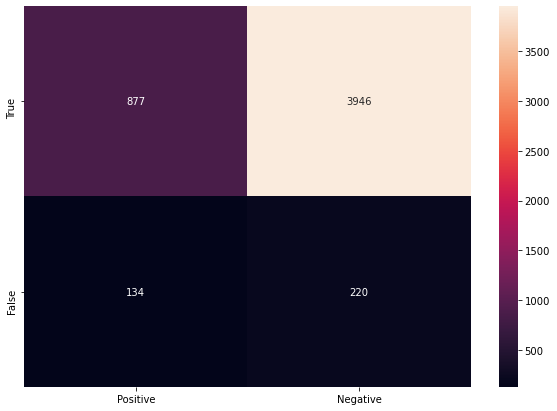

In [264]:
array = [[TP,TN],
        [FP,FN]]
df_cm = pd.DataFrame(array, index = ['True','False'],
                  columns = ['Positive','Negative'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='1g')

We may want to gear towards minimizing our false negative rate. Aka predicting areas that arent foreground as foreground

In [265]:
#https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/

In [266]:
#https://gist.github.com/CMCDragonkai/1be3402e261d3c239a307a3346360506

## Deployment

In [267]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [268]:
image = cv2.imread('.'+test1['root'][1]+test1['filename'][33])

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

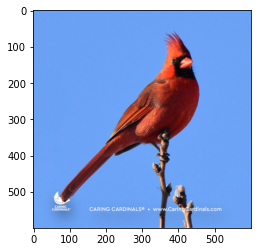

In [269]:
plt.imshow(image)

In [270]:
ss.setBaseImage(image)
        
ss.switchToSelectiveSearchFast()
rects = ss.process()
#rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))

In [271]:
print(len(rects))
rects[:10]

948


array([[355, 480,  19,  65],
       [406, 487,  12,  31],
       [199, 255, 134, 112],
       [375, 283,  68,  74],
       [ 81,  73, 375, 450],
       [116, 460,  46,  46],
       [ 63, 384, 123, 129],
       [333, 333,  37,  67],
       [221, 369, 124,  32],
       [369, 207,  96, 208]], dtype=int32)

In [272]:
image.shape

(600, 600, 3)

In [273]:
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<700:
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)

In [274]:
test_sample_array=np.array(test_sample)

In [275]:
test_sample_array.shape

(700, 224, 224, 3)

In [276]:
# nsamples,nx,ny,c=test_sample_array.shape
# test_sample_array=test_sample_array.reshape((nsamples,nx*ny,c))

In [277]:
test_sample_array.shape

(700, 224, 224, 3)

### Predictions

In [278]:
test_sample_preds=cnn.predict(test_sample_array)

In [279]:
test_sample_preds[:5]

array([[1.9735678e-13],
       [4.9392473e-13],
       [4.4252926e-09],
       [7.8097645e-10],
       [9.9608970e-01]], dtype=float32)

In [284]:
fore=[]
for sample,label in zip(items,test_sample_preds):
    if label==1:
        fore.append(sample)

In [285]:
fore

[array([ 47,  56, 410, 497], dtype=int32)]

In [286]:
image = cv2.imread('.'+test1['root'][13]+test1['filename'][33])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

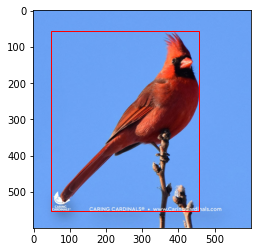

In [287]:
fig,ax=plt.subplots(1)
for i in fore:
    x,y,w,h=i
    box=patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='red',facecolor='none')
    ax.add_patch(box)
    
plt.imshow(image)

Only prediction for this guy.

In [288]:
fore[:6]

[array([ 47,  56, 410, 497], dtype=int32)]

In [289]:
myarray = np.asarray(fore)

In [290]:
myarray

array([[ 47,  56, 410, 497]], dtype=int32)

In [291]:
print('jo')

jo


In [292]:
images = [
('.'+test1['root'][16]+test1['filename'][16]
, myarray)]

395


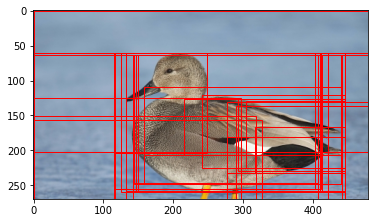

In [295]:
image = cv2.imread('.'+test1['root'][1]+test1['filename'][49])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<700:
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)       
test_sample_preds=cnn.predict(test_sample_array)
fore=[]
for sample,label in zip(items,test_sample_preds):
    if label>.99:
        fore.append(sample)
        
fig,ax=plt.subplots(1)
for i in fore:
    x,y,w,h=i
    box=patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='red',facecolor='none')
    ax.add_patch(box)
    
plt.imshow(image)


In [298]:
image.shape

(375, 500, 3)

850


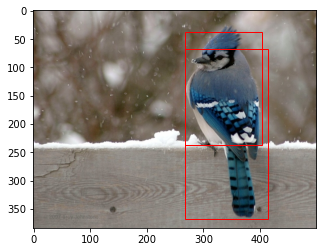

In [302]:
image = cv2.imread('.'+test1['root'][1]+test1['filename'][11])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w=image.shape[1]
h=image.shape[0]
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<1000:
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)       
test_sample_preds=cnn.predict(test_sample_array)
fore=[]
fore_score=[]
for sample,label in zip(items,test_sample_preds):
    if label==1:
        fore = list(filter(lambda x : x[0]+x[2]<w and x[1]+x[3]<h, fore))
        fore.append(sample)
        
fig,ax=plt.subplots(1)
for i in fore:
    x,y,w,h=i
    box=patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='red',facecolor='none')
    ax.add_patch(box)
    
plt.imshow(image)


In [303]:
fore

[array([268,  67, 146, 301], dtype=int32),
 array([268,  38, 136, 199], dtype=int32)]

1108


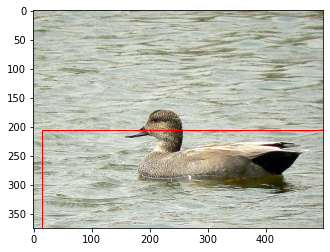

In [305]:
image = cv2.imread('.'+test1['root'][1]+test1['filename'][41])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w=image.shape[1]
h=image.shape[0]
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<1000:
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)       
test_sample_preds=cnn.predict(test_sample_array)
fore=[]
fore_score=[]
for sample,label in zip(items,test_sample_preds):
    if label>0.999:
        fore = list(filter(lambda x : x[0]+x[2]<w and x[1]+x[3]<h, fore))
        fore.append(sample)
        fore_score.append(label)
        
fig,ax=plt.subplots(1)
for i in fore:
    x,y,w,h=i
    box=patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='red',facecolor='none')
    ax.add_patch(box)
    
plt.imshow(image)


In [125]:
test_sample_preds[1]

array([1.4684582e-14], dtype=float32)

594


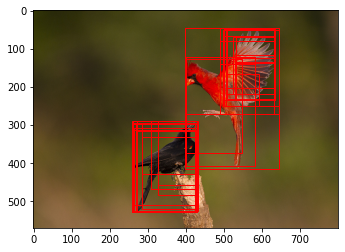

In [311]:
image = cv2.imread('./data/AT1F6839-Northern-Cardinal-&-Redwing-Blackbird-_-800.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w=image.shape[1]
h=image.shape[0]
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<1000:
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)       
test_sample_preds=cnn.predict(test_sample_array)
fore=[]
fore_score=[]
for sample,label in zip(items,test_sample_preds):
    if label>=.95:
        fore = list(filter(lambda x : x[0]+x[2]<w and x[1]+x[3]<h, fore))
        fore.append(sample)
        fore_score.append(label)
        
fig,ax=plt.subplots(1)
for i in fore:
    x,y,w,h=i
    box=patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='red',facecolor='none')
    ax.add_patch(box)
    
plt.imshow(image)


In [326]:
fore[1]

array([399,  45, 245, 226], dtype=int32)

What do we do with images that have multiple proposals. We can use non-max suppresion. Keep going if intersted.

In [354]:
non_max_suppression_slow(fore, 0)

[array([272, 315, 154, 213], dtype=int32),
 array([401, 123, 180, 285], dtype=int32),
 array([399,  45, 245, 226], dtype=int32)]

In [353]:
def non_max_suppression_slow(box, overlapThresh):
    # if there are no boxes, return an empty list
    if len(box) == 0:
        return []
     # initialize the list of picked indexes
    pick = []
     # grab the coordinates of the bounding boxes
    x1 = box[0]
    y1 = box[1]
    x2 = box[0]+box[2]
    y2 = box[1]+box[3]
     # compute the area of the bounding boxes and sort the bounding
     # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]        
        for pos in range(0,last):
            j=idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])            
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
    # return only the bounding boxes that were picked
    results=[]
    for i in pick:
        results.append(fore[i])       
    return results
        
        
        
    

594


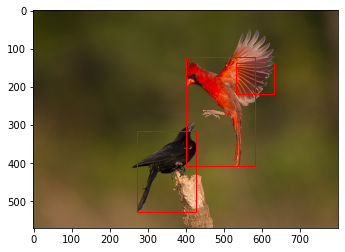

In [366]:
fore

[array([531, 139, 101,  81], dtype=int32),
 array([272, 315, 154, 213], dtype=int32),
 array([400, 123, 181, 285], dtype=int32)]

## BONUS (NMS AND SPECIES CLASSIFICATION)

## Non-Max Suppression

Were going to be write a simple non-mx suppression function that will use our IoU calculation to remove lower scoring region proposals that overlap with each other. So we end up with the 'best' region to pass in to classification. If a certain proposal has a high IoU but lower p(1), it will be deleted

In [ ]:
# for i,j in zip(fore,fore_score):
#     print(i,j)
#     box1={}
#     box1['x1']=i[0]
#     box1['y1']=i[1]
#     box1['x2']=i[0]+i[2]
#     box1['y2']=i[1]+i[3]
  
    
    

In [ ]:
# fore_sort = zip(fore,fore_score)
# sorted_score=sorted(fore_sort, key = lambda x:x[1],reverse=True)

In [ ]:
# ##Sort proposals by p('isbird')
# for i,j in sorted_score:
#     print(i,j)

In [ ]:
# type(sorted_score)

In [ ]:
# sorted_score

In [ ]:
# prio1=sorted_score[0]
# box1={}
# box1['x1']=prio1[0][0]
# box1['y1']=prio1[0][1]
# box1['x2']=prio1[0][0]+prio1[0][2]
# box1['y2']=prio1[0][1]+prio1[0][3]
# del_count=0
# for k,(i,j) in enumerate(sorted_score[1:]):
#     print(i,j)
#     box2={}
#     box2['x1']=i[0]
#     box2['y1']=i[1]
#     box2['x2']=i[0]+i[2]
#     box2['y2']=i[1]+i[3]
#     iou=calc_iou(box1,box2)
#     if iou>0.5:
#         del_count+=1
#         del sorted_score[k-del_count]
#     else:
#         continue
    

In [ ]:
# sorted_score

850


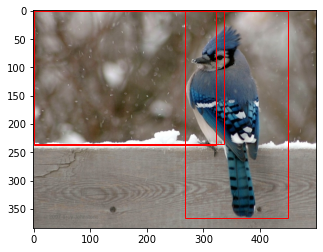

In [421]:
image = cv2.imread('.'+test1['root'][1]+test1['filename'][11])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w=image.shape[1]
h=image.shape[0]
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<1000:
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)       
test_sample_preds=cnn.predict(test_sample_array)
fore=[]
fore_score=[]
for sample,label in zip(items,test_sample_preds):
    if label>=.84:
        fore = list(filter(lambda x : x[0]+x[2]<w and x[1]+x[3]<h, fore))
        fore.append(sample)
        fore_score.append(label)
fore=non_max_suppression_slow(fore, 0.2)        
fig,ax=plt.subplots(1)
for i in fore:
    x,y,w,h=i
    box=patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='red',facecolor='none')
    ax.add_patch(box)
    
plt.imshow(image)


In [412]:
fore

[array([531,  68, 101, 152], dtype=int32),
 array([327, 291, 106, 166], dtype=int32),
 array([531, 139, 101,  81], dtype=int32)]

In [413]:
[l.tolist() for l in fore]

[[531, 68, 101, 152], [327, 291, 106, 166], [531, 139, 101, 81]]

In [414]:
fore=[l.tolist() for l in fore]

In [415]:
fore

[[531, 68, 101, 152], [327, 291, 106, 166], [531, 139, 101, 81]]

In [416]:
sample1=[]
sample1_p=[]

In [417]:
image = cv2.imread('./data/AT1F6839-Northern-Cardinal-&-Redwing-Blackbird-_-800.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
imOut=image.copy()
for i in fore:
        x1=i[0]
        y1=i[1]
        x2=i[0]+i[2]
        y2=i[1]+i[3]
    
        cimage=imOut[y1:y2,x1:x2]
        resized=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        pred=cnn1.predict(np.reshape(resized,(1,224,224,3)))
        for i in pred:
            for j in i:
                if j>0.6:
        
                    sample1.append(resized)
                    sample1_p.append(pred)
                else:
                    pass
   

In [418]:
sample1_p

[array([[7.4169907e-06, 4.4483525e-07, 9.9989116e-01, 6.4866481e-06,
         1.8357225e-09, 9.4548857e-05]], dtype=float32),
 array([[1.0000000e+00, 1.1618641e-20, 3.6476564e-18, 3.8624898e-20,
         2.0850515e-17, 3.8146274e-25]], dtype=float32),
 array([[3.3908482e-06, 2.3246016e-14, 9.9999666e-01, 1.2380437e-14,
         5.1478769e-23, 8.0242230e-11]], dtype=float32)]

594


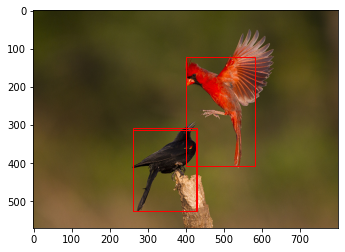

In [422]:
image = cv2.imread('./data/AT1F6839-Northern-Cardinal-&-Redwing-Blackbird-_-800.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w=image.shape[1]
h=image.shape[0]
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<1000:
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)       
test_sample_preds=cnn.predict(test_sample_array)
fore=[]
fore_score=[]
for sample,label in zip(items,test_sample_preds):
    if label>=.84:
        fore = list(filter(lambda x : x[0]+x[2]<w and x[1]+x[3]<h, fore))
        fore.append(sample)
        fore_score.append(label)
fore=non_max_suppression_slow(fore, 0.1)        
fig,ax=plt.subplots(1)
for i in fore:
    x,y,w,h=i
    box=patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='red',facecolor='none')
    ax.add_patch(box)
    
plt.imshow(image)
sample1=[]
sample1_p=[]

for i in fore:
        x1=i[0]
        y1=i[1]
        x2=i[0]+i[2]
        y2=i[1]+i[3]
    
        cimage=imout[y1:y2,x1:x2]
        resized=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        pred=cnn1.predict(np.reshape(resized,(1,224,224,3)))
        for i in pred:
            for j in i:
                if j>0.6:
        
                    sample1.append(resized)
                    sample1_p.append(pred)
                else:
                    pass
sample1_p

In [427]:
sample1=[]
sample1_p=[]

for i in fore:
        x1=i[0]
        y1=i[1]
        x2=i[0]+i[2]
        y2=i[1]+i[3]
    
        cimage=imout[y1:y2,x1:x2]
        resized=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        pred=cnn1.predict(np.reshape(resized,(1,224,224,3)))
        for i in pred:
            for j in i:
                if j>0.6:
        
                    sample1.append(resized)
                    sample1_p.append(pred)
                else:
                    pass
   

In [428]:
sample1_p

[array([[2.9080996e-10, 3.5304136e-12, 1.9716886e-11, 1.0000000e+00,
         1.7707136e-11, 2.7649164e-10]], dtype=float32),
 array([[1.000000e+00, 0.000000e+00, 4.107806e-12, 0.000000e+00,
         0.000000e+00, 0.000000e+00]], dtype=float32),
 array([[7.5169105e-14, 2.3539120e-16, 6.3609261e-15, 1.0000000e+00,
         3.9909656e-15, 3.2407388e-13]], dtype=float32)]

395


[array([[1.9209903e-04, 1.0774962e-03, 5.5118423e-04, 4.3664016e-03,
         1.5075739e-01, 8.4305543e-01]], dtype=float32),
 array([[1.3889566e-05, 3.4417750e-05, 2.5311781e-05, 4.7187298e-03,
         9.6106380e-01, 3.4143791e-02]], dtype=float32),
 array([[4.2336782e-05, 1.5515464e-04, 8.6037944e-05, 1.0488028e-02,
         8.1834412e-01, 1.7088440e-01]], dtype=float32)]

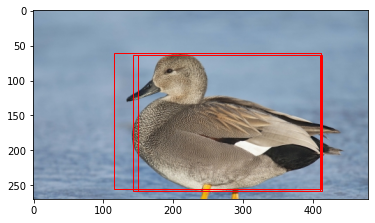

## Species Classifier

In [129]:
train_images_s=[]
train_labels_s=[]

In [130]:
for i,item in enumerate(train2['filename']):


    box1={}
    box1['x1']=round(float(train2['x1'][i]))
    box1['x2']=round(float(train2['x2'][i]))
    box1['y1']=round(float(train2['y1'][i]))
    box1['y2']=round(float(train2['y2'][i]))
        
        
        
    image = cv2.imread('.'+train2['root'][i]+train2['filename'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imout=image.copy()
    if 'Red_Winged' in train2['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        train_images_s.append(resized)
        train_labels_s.append(1)
    if 'Blue_Jay' in train2['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        train_images_s.append(resized)
        train_labels_s.append(2)
    if 'Cardinal' in train2['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        train_images_s.append(resized)
        train_labels_s.append(3)
    if 'Horned_Grebe' in train2['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        train_images_s.append(resized)
        train_labels_s.append(4)
    if 'Gadwall' in train2['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        train_images_s.append(resized)
        train_labels_s.append(5)
    if 'Western' in train2['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        train_images_s.append(resized)
        train_labels_s.append(6)
    else:
        continue

0 Blue_Jay_00.jpg
1 Blue_Jay_001.jpg
2 Blue_Jay_00111.jpg
3 Blue_Jay_0031.jpg
4 Blue_Jay_00343.jpg
5 Blue_Jay_0038_62784.jpg
6 Blue_Jay_0044_62759.jpg
7 Blue_Jay_0048_62433.jpg
8 Blue_Jay_0049_63082.jpg
9 Blue_Jay_0050_62974.jpg
10 Blue_Jay_0052_63148.jpg
11 Blue_Jay_0053_62744.jpg
12 Blue_Jay_0054_61656.jpg
13 Blue_Jay_0055_61507.jpg
14 Blue_Jay_0060_62570.jpg
15 Blue_Jay_0062_62585.jpg
16 Blue_Jay_00644.jpg
17 Blue_Jay_0066.jpg
18 Blue_Jay_0068_61543.jpg
19 Blue_Jay_0070_63684.jpg
20 Blue_Jay_0072_62944.jpg
21 Blue_Jay_0074_63487.jpg
22 Blue_Jay_0075_63021.jpg
23 Blue_Jay_0076.jpg
24 Blue_Jay_0078_62351.jpg
25 Blue_Jay_0081_61714.jpg
26 Blue_Jay_0082_62524.jpg
27 Blue_Jay_0083_61492.jpg
28 Blue_Jay_0085_62831.jpg
29 Blue_Jay_0087.jpg
30 Blue_Jay_0088_63264.jpg
31 Blue_Jay_0092_61654.jpg
32 Blue_Jay_0094_62698.jpg
33 Blue_Jay_0096_63330.jpg
34 Blue_Jay_0099_64435.jpg
35 Cardinal_0010_18894.jpg
36 Cardinal_0011.jpg
37 Cardinal_0012.jpg
38 Cardinal_00120.jpg
39 Cardinal_00121.jpg
40 Car

278 Gadwall_0049_30936_jpg_60.jpg
279 Cardinal_001222_jpg_61.jpg
280 Cardinal_00126_jpg_62.jpg
281 Western_Meadowlark_0116_77862_jpg_63.jpg
282 Blue_Jay_0052_63148_jpg_64.jpg
283 Blue_Jay_0078_62351_jpg_65.jpg
284 Western_Meadowlark_0077_77814_jpg_66.jpg
285 Western_Meadowlark_0040_77823_jpg_67.jpg
286 Western_Meadowlark_0103_78500_jpg_68.jpg
287 Western_Meadowlark_0107_78608_jpg_69.jpg
288 Horned_Grebe_0017_35073_jpg_70.jpg
289 Cardinal_0104_17122_jpg_71.jpg
290 Western_Meadowlark_0029_78832_jpg_72.jpg
291 Horned_Grebe_0005_34657_jpg_73.jpg
292 Cardinal_15542_jpg_74.jpg
293 Gadwall_0058_31660_jpg_75.jpg
294 Gadwall_0082_31301_jpg_76.jpg
295 Blue_Jay_0094_62698_jpg_77.jpg
296 Gadwall_0042_31411_jpg_78.jpg
297 Blue_Jay_0050_62974_jpg_79.jpg
298 Horned_Grebe_0002_34577_jpg_80.jpg
299 Gadwall_0095_30911_jpg_81.jpg
300 Western_Meadowlark_0024_78432_jpg_82.jpg
301 Western_Meadowlark_0013_77712_jpg_83.jpg
302 Red_Winged_Blackbird_019_jpg_84.jpg
303 Western_Meadowlark_0081_77798_jpg_85.jpg
30

493 Western_Meadowlark_0116_77862_jpg_275.jpg
494 Cardinal_0104_17122_jpg_276.jpg
495 Gadwall_0059_31646_jpg_277.jpg
496 Western_Meadowlark_0015_78610_jpg_278.jpg
497 Western_Meadowlark_0032_78633_jpg_279.jpg
498 Western_Meadowlark_0022_78410_jpg_280.jpg
499 Red_Winged_Blackbird_0058_4141_jpg_281.jpg
500 Gadwall_0084_31135_jpg_282.jpg
501 Western_Meadowlark_0050_77864_jpg_283.jpg
502 Horned_Grebe_0099_34989_jpg_284.jpg
503 Western_Meadowlark_0115_77882_jpg_285.jpg
504 Gadwall_0097_30893_jpg_286.jpg
505 Red_Winged_Blackbird_0074_4146_jpg_287.jpg
506 Western_Meadowlark_0038_77785_jpg_288.jpg
507 Horned_Grebe_0100_34462_jpg_289.jpg
508 Red_Winged_Blackbird_0061_4196_jpg_290.jpg
509 Blue_Jay_0088_63264_jpg_291.jpg
510 Horned_Grebe_0064_35015_jpg_292.jpg
511 Blue_Jay_00_jpg_293.jpg
512 Blue_Jay_0062_62585_jpg_294.jpg
513 Western_Meadowlark_0100_78037_jpg_295.jpg
514 Horned_Grebe_0066_34738_jpg_296.jpg
515 Western_Meadowlark_0044_77758_jpg_297.jpg
516 Western_Meadowlark_0033_78312_jpg_298.jp

In [131]:
test_images_s=[]
test_labels_s=[]

In [132]:
for i,item in enumerate(test1['filename']):


    box1={}
    box1['x1']=round(float(test1['x1'][i]))
    box1['x2']=round(float(test1['x2'][i]))
    box1['y1']=round(float(test1['y1'][i]))
    box1['y2']=round(float(test1['y2'][i]))
        
        
        
    image = cv2.imread('.'+test1['root'][i]+test1['filename'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imout=image.copy()
    if 'Red_Winged' in test1['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        test_images_s.append(resized)
        test_labels_s.append(1)
    if 'Blue_Jay' in test1['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        test_images_s.append(resized)
        test_labels_s.append(2)
    if 'Cardinal' in test1['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        test_images_s.append(resized)
        test_labels_s.append(3)
    if 'Horned_Grebe' in test1['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        test_images_s.append(resized)
        test_labels_s.append(4)
    if 'Gadwall' in test1['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        test_images_s.append(resized)
        test_labels_s.append(5)
    if 'Western' in test1['filename'][i]:
        print(i,item)
        timage=imout[box1['y1']:box1['y2'],box1['x1']:box1['x2']]
        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
        test_images_s.append(resized)
        test_labels_s.append(6)
    else:
        continue
        

0 Blue_Jay_0002_62657.jpg
1 Blue_Jay_0003_63408.jpg
2 Blue_Jay_0006_63504.jpg
3 Blue_Jay_0009_62873.jpg
4 Blue_Jay_0013_61463.jpg
5 Blue_Jay_0015_62916.jpg
6 Blue_Jay_0020_63604.jpg
7 Blue_Jay_0022_63074.jpg
8 Blue_Jay_0024_63167.jpg
9 Blue_Jay_0027_63133.jpg
10 Blue_Jay_0028_63599.jpg
11 Blue_Jay_0031_62913.jpg
12 Blue_Jay_0033_62024.jpg
13 Blue_Jay_0035_63560.jpg
14 Blue_Jay_0079_62626.jpg
15 Blue_Jay_0080_61617.jpg
16 Blue_Jay_0102_61494.jpg
17 Cardinal_0006_17684.jpg
18 Cardinal_0033_19215.jpg
19 Cardinal_0035_17678.jpg
20 Cardinal_0037_18092.jpg
21 Cardinal_0040_17477.jpg
22 Cardinal_0057_17128.jpg
23 Cardinal_0060_17139.jpg
24 Cardinal_0062_17334.jpg
25 Cardinal_0066_17803.jpg
26 Cardinal_0072_17159.jpg
27 Cardinal_0082_17875.jpg
28 Cardinal_1.jpg
29 Cardinal_100.jpg
30 Cardinal_122.jpg
31 Cardinal_131.jpg
32 Cardinal_134.jpg
33 Cardinal_151.jpg
34 Gadwall female SWP2 (c) Derek Moore.jpg
35 Gadwall.jpg
36 Gadwall_0004_31669.jpg
37 Gadwall_0005_30924.jpg
38 Gadwall_0009_31847.jpg


In [133]:
X_train_s=np.array(train_images_s)

y_train_s=np.array(train_labels_s)
X_test_s=np.array(test_images_s)
y_test_s=np.array(test_labels_s)

In [134]:
X_train_s.shape

(646, 224, 224, 3)

In [135]:
X_test_s.shape

(102, 224, 224, 3)

In [136]:
from sklearn.preprocessing import OneHotEncoder

In [137]:
oh=OneHotEncoder(sparse=False,dtype=int,categories='auto')
y_train_s=oh.fit_transform(y_train_s.reshape(-1,1))
y_test_s=oh.transform(y_test_s.reshape(-1,1))

In [187]:
cnn1 = Sequential()
#cnn1.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
cnn1.add(Conv2D(32, (3, 3),input_shape=(224,224,3), activation='relu'))
#cnn1.add(ZeroPadding2D((1,1)))
cnn1.add(Conv2D(32, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2,2), strides=(2,2)))
#cnn1.add(ZeroPadding2D((1,1)))
cnn1.add(Conv2D(64, (3, 3), activation='relu'))
#cnn1.add(ZeroPadding2D((1,1)))
cnn1.add(Conv2D(64, (3, 3), activation='relu'))
# cnn1.add(ZeroPadding2D((1,1)))
# cnn1.add(Conv2D(256, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2,2), strides=(2,2)))
#cnn1.add(ZeroPadding2D((1,1)))
cnn1.add(Conv2D(128, (3, 3), activation='relu'))

cnn1.add(Conv2D(128, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2,2), strides=(2,2)))
cnn1.add(Conv2D(256, (3, 3), activation='relu'))

cnn1.add(Conv2D(256, (3, 3), activation='relu'))
cnn1.add(MaxPooling2D((2,2), strides=(2,2)))
cnn1.add(Flatten())





cnn1.add(Dense(256, activation='relu'))
cnn1.add(Dropout(0.2))
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dropout(0.2))
#cnn1.add(Dense(500, activation='softmax'))
cnn1.add(Dense(6,activation='softmax'))


In [188]:
early_stop=EarlyStopping(monitor='val_accuracy',min_delta=0,patience=5,verbose=1,mode='auto')

In [189]:
cnn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#early_stop=EarlyStopping(monitor='val_accuracy',min_delta=0,patience=5,verbose=1,mode='auto')
history = cnn1.fit(X_train_s,
                        y_train_s,
                        batch_size=32,
                        validation_data=(X_test_s, y_test_s),
                        epochs=50,
                        verbose=1,callbacks=[early_stop])

Train on 646 samples, validate on 102 samples
Epoch 1/50
646/646 [==============================] - 7s 11ms/sample - loss: 3.3563 - accuracy: 0.2415 - val_loss: 1.5009 - val_accuracy: 0.3922
Epoch 2/50
646/646 [==============================] - 6s 9ms/sample - loss: 1.5202 - accuracy: 0.3638 - val_loss: 1.7811 - val_accuracy: 0.1667
Epoch 3/50
646/646 [==============================] - 6s 9ms/sample - loss: 1.4864 - accuracy: 0.3251 - val_loss: 1.3559 - val_accuracy: 0.3922
Epoch 4/50
646/646 [==============================] - 6s 9ms/sample - loss: 1.3002 - accuracy: 0.4412 - val_loss: 1.1952 - val_accuracy: 0.4020
Epoch 5/50
646/646 [==============================] - 6s 9ms/sample - loss: 1.1731 - accuracy: 0.4783 - val_loss: 1.2191 - val_accuracy: 0.5882
Epoch 6/50
646/646 [==============================] - 6s 9ms/sample - loss: 1.1209 - accuracy: 0.5433 - val_loss: 1.0383 - val_accuracy: 0.6471
Epoch 7/50
646/646 [==============================] - 6s 9ms/sample - loss: 0.9031 - accu

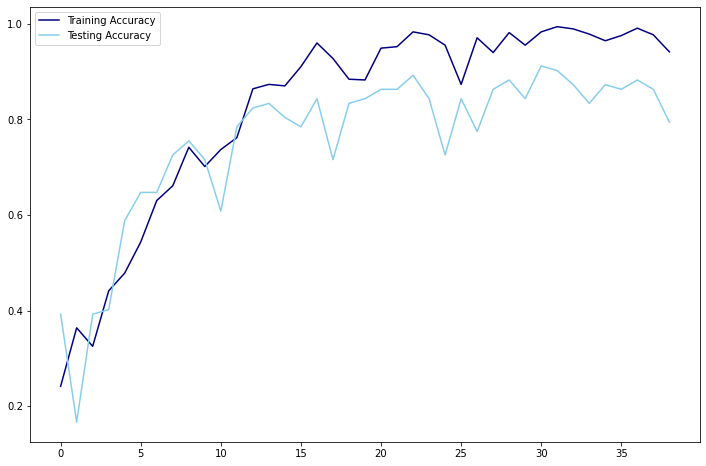

In [190]:
train_loss=history.history['accuracy']
test_loss=history.history['val_accuracy']
plt.figure(figsize=(12,8))
plt.plot(train_loss,label='Training Accuracy', color='navy')
plt.plot(test_loss,label='Testing Accuracy',color='skyblue')
plt.legend();

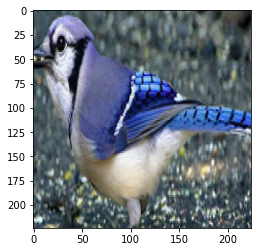

In [191]:
plt.imshow(X_test_s[13])

In [192]:
X_test_s[13].shape

(224, 224, 3)

In [193]:
cnn1.predict(np.reshape(X_test_s[13],(1,224,224,3)))

array([[0.0015305 , 0.02967806, 0.00207123, 0.91350424, 0.01218388,
        0.04103208]], dtype=float32)

In [224]:
fore

[array([ 66,  87, 292, 198], dtype=int32),
 array([ 55,  63, 259, 219], dtype=int32),
 array([ 49,  62, 266, 231], dtype=int32),
 array([  0,   0, 500, 280], dtype=int32),
 array([213, 214, 261, 143], dtype=int32),
 array([156,  81, 344, 163], dtype=int32),
 array([ 26,  33, 300, 176], dtype=int32)]

In [232]:
sample1=[]
sample1_p=[]

In [233]:
image = cv2.imread('.'+test1['root'][1]+test1['filename'][14])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
imOut=image.copy()

for i in fore:
        x1=i[0]
        y1=i[1]
        x2=i[0]+i[2]
        y2=i[1]+i[3]
    
        cimage=imOut[y1:y2,x1:x2]
        resized=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        pred=cnn1.predict(np.reshape(resized,(1,224,224,3)))
        
        
        sample1.append(resized)
        sample1_p.append(pred)
   

    

In [238]:
sample1_p

[array([[0.03099129, 0.670597  , 0.01929067, 0.04049933, 0.14238642,
         0.09623532]], dtype=float32),
 array([[0.01560657, 0.56819665, 0.00402405, 0.33093464, 0.02449399,
         0.056744  ]], dtype=float32),
 array([[0.01549313, 0.7631137 , 0.00350355, 0.13142534, 0.03501115,
         0.0514532 ]], dtype=float32),
 array([[3.0411294e-04, 1.6614452e-02, 1.1673722e-03, 1.6454442e-03,
         1.3250680e-01, 8.4776181e-01]], dtype=float32),
 array([[0.00676839, 0.15192863, 0.00080074, 0.00554153, 0.57293737,
         0.26202333]], dtype=float32),
 array([[1.6772788e-03, 6.2674098e-03, 6.0186221e-04, 2.8683201e-03,
         5.4927059e-03, 9.8309237e-01]], dtype=float32),
 array([[0.00515898, 0.7258891 , 0.00096044, 0.01901726, 0.05872707,
         0.19024716]], dtype=float32)]

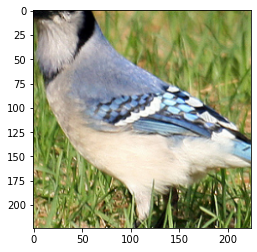

In [235]:
plt.imshow(sample1[2])

In [236]:
sample1_p[2]

array([[0.01549313, 0.7631137 , 0.00350355, 0.13142534, 0.03501115,
        0.0514532 ]], dtype=float32)

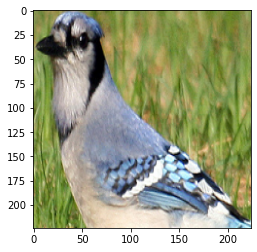

In [237]:
plt.imshow(resized)

In [ ]:
#rects = list(filter(lambda x : x[2]<x[3]*3 and x[3]<x[2]*3, rects))

In [ ]:
# if (box1['x2']-box1['x1'])>(box1['y2']-box1['y1']):
#     rects = list(filter(lambda x : x[2]>x[3], rects))
# else:
#     rects = list(filter(lambda x : x[2]<=x[3], rects))


559


[array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.5736378e-37,
         1.0000000e+00, 0.0000000e+00]], dtype=float32),
 array([[0.8288426 , 0.01168996, 0.01346421, 0.01221814, 0.04389723,
         0.08988786]], dtype=float32),
 array([[1.3928024e-15, 3.1383504e-27, 3.9171089e-20, 1.0000000e+00,
         1.3130309e-24, 6.3199856e-20]], dtype=float32),
 array([[1., 0., 0., 0., 0., 0.]], dtype=float32)]

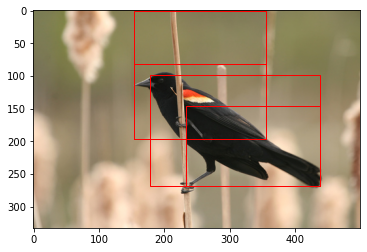

In [456]:
image = cv2.imread('.'+test1['root'][1]+test1['filename'][78])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
w=image.shape[1]
h=image.shape[0]
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))
rects[:10]
test_sample=[]
items=[]
imout=image.copy()
for i,item in enumerate(rects):
    if i<1000:
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)       
test_sample_preds=cnn.predict(test_sample_array)
fore=[]
fore_score=[]
for sample,label in zip(items,test_sample_preds):
    if label>=.99:
        fore = list(filter(lambda x : x[0]+x[2]<w and x[1]+x[3]<h, fore))
        fore.append(sample)
        fore_score.append(label)
fore=non_max_suppression_slow(fore, 0.9)
fig,ax=plt.subplots(1)
for i in fore:
    x,y,w,h=i
    box=patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='red',facecolor='none')
    ax.add_patch(box)
    
plt.imshow(image)
sample1=[]
sample1_p=[]

for i in fore:
        x1=i[0]
        y1=i[1]
        x2=i[0]+i[2]
        y2=i[1]+i[3]
    
        cimage=imout[y1:y2,x1:x2]
        resized=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        pred=cnn1.predict(np.reshape(resized,(1,224,224,3)))
        for j in pred:
            for k in j:
                if k>0.6:
        
                    sample1.append((x1,y1,x2,y2))
                    sample1_p.append(pred)
                else:
                    pass
sample1_p